## OVERVIEW
---
* Exploratory Data Analysis
* Data Cleaning and Feature selection
* Data Sampling
* Text Preprocessing
    * Punctuation, Stopwords
    * Stemming and Lemmatizing
* Predictive Modelling
    * Random Forest Classifier
    * LinearSVC
    * Logistic Regression
    * XGBClassifier
    * Stochastic Gradient Descent

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize

from wordcloud import WordCloud,STOPWORDS
from string import punctuation
from bs4 import BeautifulSoup
import re,string,unicodedata
from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.gaussian_process import GaussianProcessClassifier


from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,plot_confusion_matrix

import keras
from keras.models import Sequential, Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Masking


### GET THE DATA

In [2]:
df = pd.read_csv('../input/dataisbeautiful/r_dataisbeautiful_posts.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (5,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## EDA
---

In [3]:
#show dataframe
df.head()

,id,title,score,author,author_flair_text,removed_by,total_awards_received,awarders,created_utc,full_link,num_comments,over_18
0,hbyv2e,[OC] How Bar Chart Race Animation Can be Creat...,1,Tom10AE,NaN,NaN,0.0,[],1592565317,https://www.reddit.com/r/dataisbeautiful/comme...,0,False
1,hbynoy,[UK] Labour and Conservative vote share by age...,1,Ge0rgeBr0ughton,NaN,NaN,0.0,[],1592564316,https://www.reddit.com/r/dataisbeautiful/comme...,1,False
2,hbym2y,[NOC] Number of wallets returned across the wo...,1,i_am_shattered,NaN,NaN,0.0,[],1592564089,https://www.reddit.com/r/dataisbeautiful/comme...,1,False
3,hbyirw,Largest Banana Producing Countries (1961-2020)...,1,Bilal078692,NaN,moderator,0.0,[],1592563628,https://www.reddit.com/r/dataisbeautiful/comme...,0,False
4,hby1fy,[OC] Popular Combinations for the StamiStudios...,1,shahinrostami,Viz Researcher,NaN,0.0,[],1592561119,https://www.reddit.com/r/dataisbeautiful/comme...,2,False


In [4]:
#show feature data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183891 entries, 0 to 183890
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     183891 non-null  object 
 1   title                  183890 non-null  object 
 2   score                  183891 non-null  int64  
 3   author                 183891 non-null  object 
 4   author_flair_text      24574 non-null   object 
 5   removed_by             11564 non-null   object 
 6   total_awards_received  44007 non-null   float64
 7   awarders               33332 non-null   object 
 8   created_utc            183891 non-null  int64  
 9   full_link              183891 non-null  object 
 10  num_comments           183891 non-null  int64  
 11  over_18                183891 non-null  bool   
dtypes: bool(1), float64(1), int64(3), object(7)
memory usage: 15.6+ MB


In [5]:
#show data basic stats by over_18 feature
df.groupby('over_18').describe()

score                                                         \
            count        mean         std  min  25%  50%   75%       max   
over_18                                                                    
False    182948.0  184.110080  1952.99156  0.0  1.0  1.0   5.0  116226.0   
True        943.0  679.826087  4058.60792  0.0  1.0  1.0  12.0   63569.0   

        total_awards_received            ...   created_utc                \
                        count      mean  ...           75%           max   
over_18                                  ...                               
False                 43712.0  0.003615  ...  1.554148e+09  1.592565e+09   
True                    295.0  0.006780  ...  1.565761e+09  1.592517e+09   

        num_comments                                                       
               count       mean         std  min  25%  50%   75%      max  
over_18                                                                    
False       182948.0  25.008440  193.309693  0.0  1.0  1.0   4.0  18801.0  
True           943.0  97.903499  455.763581  0.0  1.0  3.0  12.0   7121.0  

[2 rows x 32 columns]

In [6]:
#replace the boolean values on over_18 to numerical values
def replace_labels(x):
    if x == False:
        return 0
    else:
        return 1

df['over_18'] = df['over_18'].apply(replace_labels)

### CHECK NULL VALUES

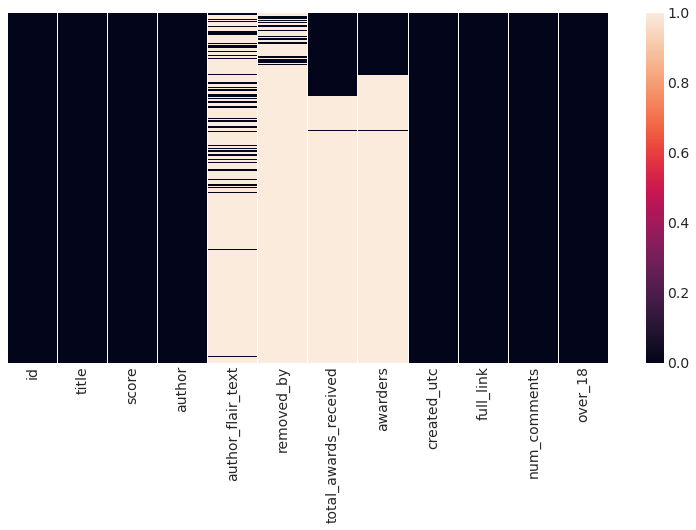

In [7]:
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), yticklabels=False);

In [8]:
df.isnull().sum()

id                            0
title                         1
score                         0
author                        0
author_flair_text        159317
removed_by               172327
total_awards_received    139884
awarders                 150559
created_utc                   0
full_link                     0
num_comments                  0
over_18                       0
dtype: int64

### FEATURE SELECTION

In [9]:
df.drop(['id', 'author_flair_text', 'removed_by',
         'total_awards_received', 'awarders', 'created_utc', 'full_link'],
        axis=1, inplace=True)

In [10]:
#add title character length feature
df['title_length'] = df['title'].apply(lambda x: len(str(x)))

In [11]:
df = df.dropna()
print('DATAFRAME SHAPE: ',df.shape)
df.head()

DATAFRAME SHAPE:  (183890, 6)


,title,score,author,num_comments,over_18,title_length
0,[OC] How Bar Chart Race Animation Can be Creat...,1,Tom10AE,0,0,119
1,[UK] Labour and Conservative vote share by age...,1,Ge0rgeBr0ughton,1,0,62
2,[NOC] Number of wallets returned across the wo...,1,i_am_shattered,1,0,50
3,Largest Banana Producing Countries (1961-2020)...,1,Bilal078692,0,0,51
4,[OC] Popular Combinations for the StamiStudios...,1,shahinrostami,2,0,63


In [12]:
df.isnull().sum()

title           0
score           0
author          0
num_comments    0
over_18         0
title_length    0
dtype: int64

### SHOW COUNTPLOT OF OVER_18 LABELS

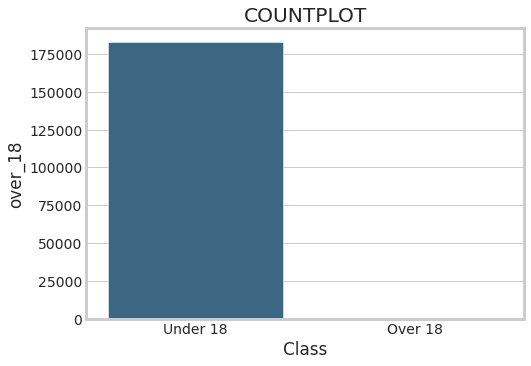

In [13]:
plt.figure(figsize=(7,5))
plt.title('COUNTPLOT')
plt.xlabel('Class')
plt.ylabel('Count')
sns.barplot(x=['Under 18', 'Over 18'],y= df.over_18.value_counts(), palette='viridis');

In [14]:
df.over_18.value_counts()

0    182947
1       943
Name: over_18, dtype: int64

### DISTRIBUTION PER TITLE CHARACTER LENGHT

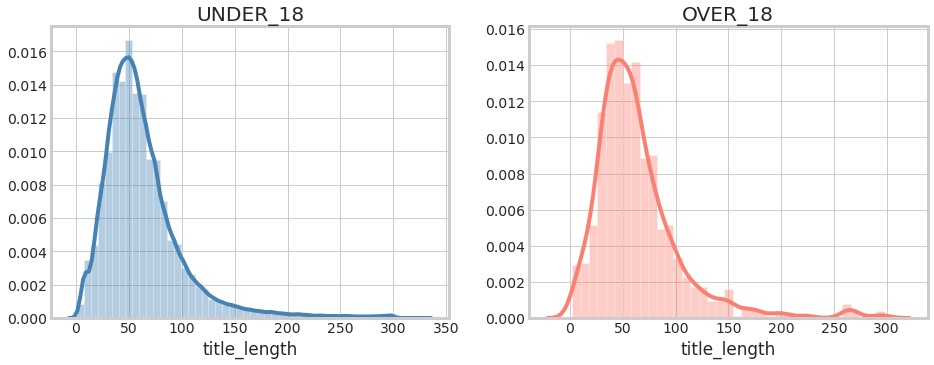

In [15]:
fig, ax = plt.subplots(1,2, figsize=(14,5))
ax[0].set_title('UNDER_18')
ax[1].set_title('OVER_18')

sns.distplot(df[df['over_18']==0]['title_length'], ax=ax[0], color='steelblue');
sns.distplot(df[df['over_18']==1]['title_length'], ax=ax[1], color='salmon');

In [16]:
#drop data which title character lenght is less than 5
df.drop(df[df['title_length']<5].index, inplace =True)

In [17]:
# combine author and title
df['text'] = df['title'] + ' ' + df['author']
df.drop(['title', 'author'], axis=1, inplace=True)

In [18]:
df.over_18.value_counts()

0    182512
1       940
Name: over_18, dtype: int64

#### REDUCING THE DATA BY ONLY TAKING SAMPLES
* From the distribution plot above, we can see that most of data in under_18 class have a 25-75 character length. so i'll take samples from that range.

In [19]:
SAMPLES = 10000

under_18 = df[df['over_18']==0]
under_18 = under_18[(under_18['title_length']>25) & (under_18['title_length']<75)].sample(frac=1)
under_18 = under_18[:SAMPLES]
over_18 = df[df['over_18']==1]

df_train = pd.concat([under_18, over_18])
df_train.index = np.arange(len(df_train))

#check data frame
print('SHAPE: ', df_train.shape)
df_train.head()

SHAPE:  (10940, 5)


,score,num_comments,over_18,title_length,text
0,1,2,0,50,(OC) My tinder dating experience as a 13M (sat...
1,1,0,0,37,Best Primavera Institute in Hyderabad [deleted]
2,1,1,0,29,How big are your donut holes? Arshdsj
3,14,10,0,60,Most Expensive and Least Expensive Zip Codes i...
4,1,1,0,52,The Most Popular Box Office Movies From 1979 t...


In [20]:

X = df_train.drop(['score', 'num_comments', 'over_18', 'title_length'], axis=1)
y = df_train['over_18']

### WORDCLOUD UNDER 18

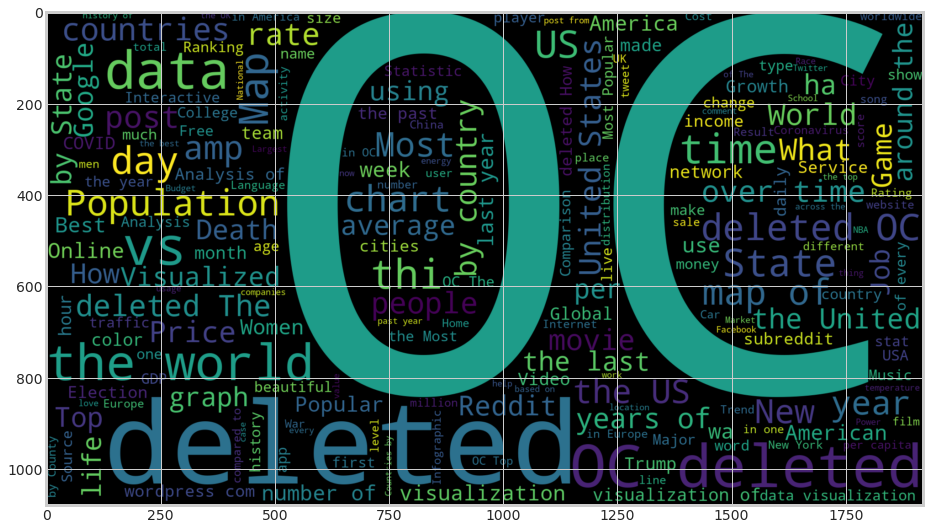

In [21]:
plt.figure(figsize=(14,10))
wc_under18 = WordCloud(min_font_size=3, max_font_size=3000, 
                       width=1920, height=1080, 
                       stopwords=STOPWORDS).generate(str(''.join(df_train[df_train['over_18']==0]['text'])))

plt.imshow(wc_under18, interpolation='bilinear');

### WORDCLOUD OVER_18

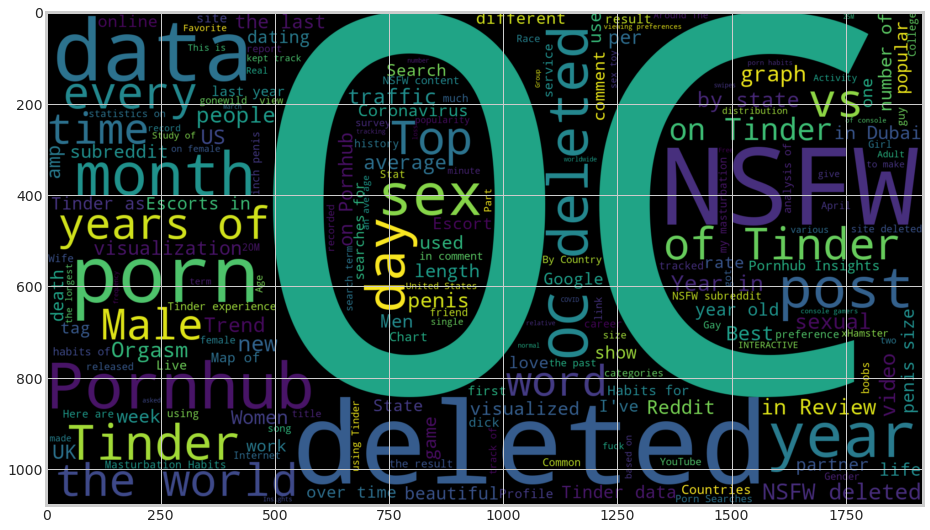

In [46]:
plt.figure(figsize=(14,10))
wc_over18 = WordCloud(min_font_size=3, max_font_size=3000, 
                       width=1920, height=1080, 
                       stopwords=STOPWORDS).generate(str(''.join(df_train[df_train['over_18']==1]['text'])))

plt.imshow(wc_over18, interpolation='bilinear');

### MOST FREQUENT WORDS OF OVER 18

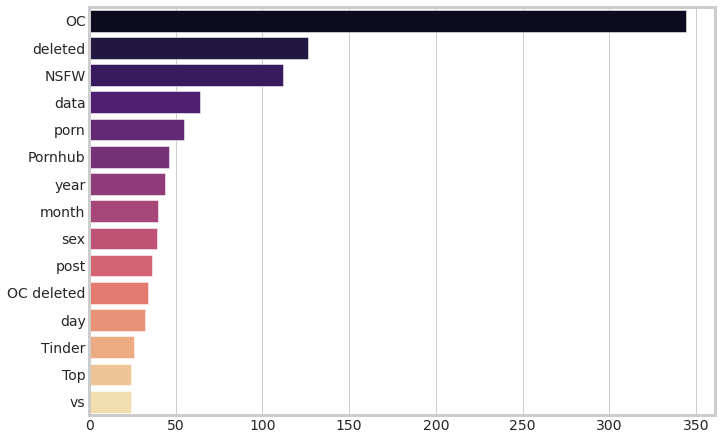

In [23]:
topwords_over_18 = pd.Series(wc_over18.process_text(str(''.join(df_train[df_train['over_18']==1]['text'])))).sort_values(ascending=False)[:15]

plt.figure(figsize=(10,7))
sns.barplot(topwords_over_18.values, topwords_over_18.index, palette='magma');

### MOST FREQUENT WORDS OF UNDER 18

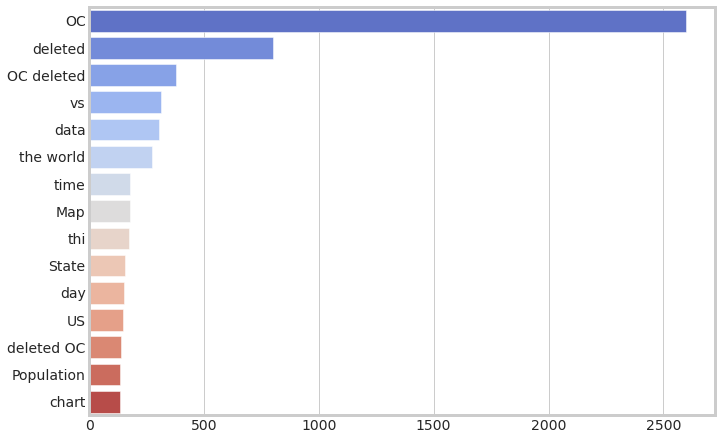

In [24]:
topwords_under_18 = pd.Series(wc_over18.process_text(str(''.join(df_train[df_train['over_18']==0]['text'])))).sort_values(ascending=False)[:15]

plt.figure(figsize=(10,7))
sns.barplot(topwords_under_18.values, topwords_under_18.index, palette='coolwarm');

* OC, OC deleted, deleted are on top words, I'll remove them later by including them on stopwords because it may confuse the model.

### TEXT PREPROCESSING

In [25]:
# get the stop words, punctuation, and also add the OC, deleted and OC deleted
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)
removed_topwords = ['deleted', 'oc', 'deleted oc', 'oc deleted']
stop.update(removed_topwords)

In [26]:
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [27]:
#lematizing function
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            pos = pos_tag([i.strip()])
            word = lemmatizer.lemmatize(i.strip(),get_simple_pos(pos[0][1]))
            final_text.append(word.lower())
    return final_text

In [28]:
#process the text data
X.text = X.text.apply(lemmatize_words)

In [29]:
X.text = X.text.apply(lambda i: ' '.join(i))
#check data
X.text

0        (oc) tinder date experience 13m (satire) gemmi...
1             best primavera institute hyderabad [deleted]
2                                 big donut holes? arshdsj
3        expensive least expensive zip codes usa [oc] t...
4          popular box office movies 1979 2020 metahuman95
                               ...                        
10935            map fetish relationship (nsfw) ozymand1as
10936    gay rights state -- much, much well visualizat...
10937    set sex toy whose shape determine popularity v...
10938    [meta][nsfw] nsfw link appropriate subreddit? ...
10939    most-referenced body parts music genre (xpost ...
Name: text, Length: 10940, dtype: object

In [30]:
#split the data
X_train, X_test, y_train, y_test = train_test_split(X.text, y, test_size=0.2, random_state=101)

## PREDICTIVE MODELLING
---

### RANDOM FOREST CLASSIFIER

In [31]:
pipeline = Pipeline([
    ('count', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('model', RandomForestClassifier())
])

pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)

In [32]:
#classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      2015
           1       0.86      0.50      0.63       173

    accuracy                           0.95      2188
   macro avg       0.91      0.75      0.80      2188
weighted avg       0.95      0.95      0.95      2188



#### CONFUSION MATRIX

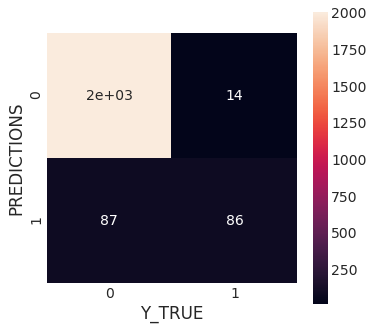

In [33]:
plt.figure(figsize=(5,5))
con_mat = confusion_matrix(y_test, predictions)

sns.heatmap(con_mat, annot=True, square=True);

plt.xlabel('Y_TRUE');
plt.ylabel('PREDICTIONS');

### LOGISTIC REGRESSION

In [34]:
pipeline = Pipeline([
    ('count', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('model', LogisticRegression())
])

pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)

In [35]:
#classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2015
           1       0.95      0.31      0.46       173

    accuracy                           0.94      2188
   macro avg       0.95      0.65      0.72      2188
weighted avg       0.94      0.94      0.93      2188



#### CONFUSION MATRIX

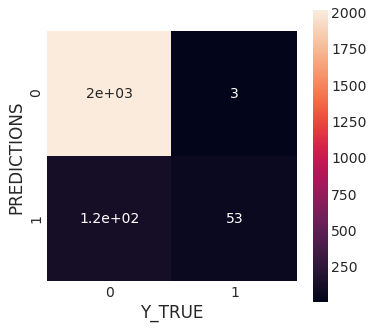

In [36]:
plt.figure(figsize=(5,5))
con_mat = confusion_matrix(y_test, predictions)

sns.heatmap(con_mat, annot=True, square=True);

plt.xlabel('Y_TRUE');
plt.ylabel('PREDICTIONS');

### LINEAR SVC

In [37]:
pipeline = Pipeline([
    ('count', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('model', LinearSVC())
])

pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)

In [38]:
#classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      2015
           1       0.87      0.51      0.65       173

    accuracy                           0.96      2188
   macro avg       0.92      0.75      0.81      2188
weighted avg       0.95      0.96      0.95      2188



#### CONFUSION MATRIX

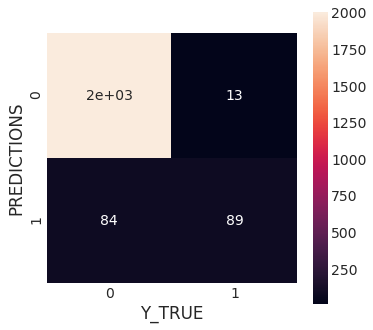

In [39]:
plt.figure(figsize=(5,5))
con_mat = confusion_matrix(y_test, predictions)

sns.heatmap(con_mat, annot=True, square=True);

plt.xlabel('Y_TRUE');
plt.ylabel('PREDICTIONS');

### XGBOOST CLASSIFIER

In [40]:
pipeline = Pipeline([
    ('count', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('model', XGBClassifier(loss = 'deviance',
                                    learning_rate = 0.02,
                                    n_estimators = 10,
                                    max_depth = 7,
                                    random_state=101))
])

pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)

[14:07:34] WARNING: /workspace/src/learner.cc:480: 
Parameters: { loss } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [41]:
#classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98      2015
           1       0.94      0.43      0.59       173

    accuracy                           0.95      2188
   macro avg       0.95      0.72      0.78      2188
weighted avg       0.95      0.95      0.94      2188



#### CONFUSION MATRIX

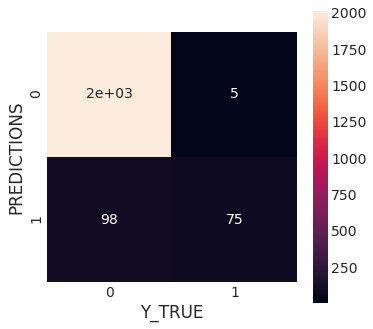

In [42]:
plt.figure(figsize=(5,5))
con_mat = confusion_matrix(y_test, predictions)

sns.heatmap(con_mat, annot=True, square=True);

plt.xlabel('Y_TRUE');
plt.ylabel('PREDICTIONS');

### SGD CLASSIFIER

In [43]:
pipeline = Pipeline([
    ('count', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('model', SGDClassifier(n_jobs=-1))
])

pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)

In [44]:
#classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      2015
           1       0.88      0.48      0.62       173

    accuracy                           0.95      2188
   macro avg       0.92      0.74      0.80      2188
weighted avg       0.95      0.95      0.95      2188



#### CONFUSION MATRIX

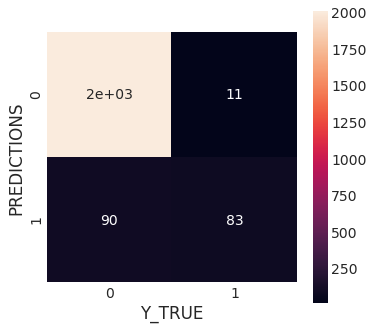

In [45]:
plt.figure(figsize=(5,5))
con_mat = confusion_matrix(y_test, predictions)

sns.heatmap(con_mat, annot=True, square=True);

plt.xlabel('Y_TRUE');
plt.ylabel('PREDICTIONS');